In [35]:
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

## Read CSV

In [36]:
TrainTestDf = pd.read_csv('preProcessedData.csv', index_col=0)
qualityDf = pd.read_csv('../data/test_data/quality_response_remapped_public.csv')

In [37]:
dropCol = ['T1','T2','T3','T4','T5']
X = TrainTestDf.drop(dropCol,axis=1)

In [38]:
testTaskDf = pd.read_csv('../data/test_data/quality_response_remapped_private.csv')
testTaskDf = testTaskDf.iloc[:,2:]
testIndex = list(set(testTaskDf.iloc[:,1]) | set(testTaskDf.iloc[:,0]))
testDf = X.loc[testIndex,:]

In [39]:
X.head()

,AnswerProba,ElseEntropy,AnswerEntropy,stdX,stdY,text_length,alphaWordCount,signWordCount,numericWordCount,avg_word_length
0,0.443457,1.316125,0.990755,170.009451,129.982344,148.0,27.0,5.0,1.0,5.481481
1,0.571429,0.650022,0.985228,165.986461,111.304075,53.0,9.0,1.0,8.0,5.888889
2,0.385214,1.560775,0.961641,197.194749,133.458086,100.0,11.0,26.0,4.0,9.090909
3,0.808757,1.564606,0.704063,188.986115,143.703961,60.0,11.0,5.0,4.0,5.454545
4,0.401408,1.568387,0.971769,190.131950,111.250841,160.0,42.0,5.0,0.0,3.809524


## Model subset selection

In [40]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [41]:
subSet = {}
for i in range(1,6):
    lrCombScores = {}
    svmCombScores = {}
    for j in range(1,11):
        for colIdx in combinations(range(0,10),j):
            scaler = StandardScaler()
            lr = LogisticRegression()
            combX = X.iloc[:,list(colIdx)]
            combX = pd.concat((combX, TrainTestDf[f'T{i}']),axis=1)
            combX.dropna(inplace=True)
            X_train = np.hstack((scaler.fit_transform(combX.iloc[:,:-1]), np.array(combX.iloc[:,-1]).reshape(-1,1)))
            lrCv = cross_validate(lr,X_train[:,:-1],X_train[:,-1],n_jobs=-1,cv=X_train.shape[1])
            lrCombScores[colIdx] = np.mean(lrCv['test_score'])
    subSet[f'lrT{i}'] = max(lrCombScores.items(), key=lambda x: x[1])
    print(subSet[f'lrT{i}'])

((0, 2, 3, 6), 0.7777777777777778)
((0, 1, 2, 3, 4, 5, 7, 9), 0.7555555555555555)
((0, 1, 8), 0.7788461538461539)
((0, 1, 3, 7), 0.7155555555555555)
((0, 1, 5, 6), 0.7577777777777779)


In [42]:
for s,_ in subSet.values():
    print(X.columns[list(s)])

Index(['AnswerProba', 'AnswerEntropy', 'stdX', 'alphaWordCount'], dtype='object')
Index(['AnswerProba', 'ElseEntropy', 'AnswerEntropy', 'stdX', 'stdY',
       'text_length', 'signWordCount', 'avg_word_length'],
      dtype='object')
Index(['AnswerProba', 'ElseEntropy', 'numericWordCount'], dtype='object')
Index(['AnswerProba', 'ElseEntropy', 'stdX', 'signWordCount'], dtype='object')
Index(['AnswerProba', 'ElseEntropy', 'text_length', 'alphaWordCount'], dtype='object')


### Validation

In [43]:
lrModels = []
lrValidScores = []
validProba = []
for i in range(1,6):
    scaler = StandardScaler()
    lr = LogisticRegression()
    colIdx = subSet[f'lrT{i}'][0]
    combX = X.iloc[:,list(colIdx)]
    combX = pd.concat((combX, TrainTestDf[f'T{i}']),axis=1)
    combX.dropna(inplace=True)
    scaler.fit(combX.iloc[:,:-1])
    X_train = np.hstack((scaler.transform(combX.iloc[:,:-1]), np.array(combX.iloc[:,-1]).reshape(-1,1)))
    fitLr = lr.fit(X_train[:,:-1],X_train[:,-1])
    lrModels.append((scaler, fitLr))
    validScore = []
    validDf = pd.concat((X.iloc[:,list(colIdx)], TrainTestDf[f'T{i}']),axis=1)
    validDf.dropna(inplace=True)
    X_valid = scaler.transform(validDf.iloc[:,:-1])
    validProba.append(fitLr.predict_proba(X_valid)[:,1])
    lrValidScores.append(validScore)

In [44]:
validProba = np.array(validProba)

In [45]:
valPredict = pd.DataFrame()
for i in range(5):
    valPredict[f'lrPred{i}'] = pd.Series(validProba[i], index=combX.index)
for i in range(5):
    valPredict[f'MeanW/O{i}'] = valPredict.iloc[:,:5].drop(f'lrPred{i}',axis=1).mean(axis=1)
valPredict['Mean'] = valPredict.iloc[:,:5].mean(axis=1)
valPredict.head()

,lrPred0,lrPred1,lrPred2,lrPred3,lrPred4,MeanW/O0,MeanW/O1,MeanW/O2,MeanW/O3,MeanW/O4,Mean
4,0.605707,0.866615,0.857394,0.435235,0.796740,0.738996,0.673769,0.676074,0.781614,0.691238,0.712338
16,0.598800,0.572460,0.337094,0.323768,0.367711,0.400258,0.406843,0.465685,0.469016,0.458031,0.439967
27,0.483569,0.774240,0.666031,0.521821,0.483385,0.611369,0.538702,0.565754,0.601806,0.611415,0.585809
56,0.470067,0.487739,0.619220,0.541394,0.470464,0.529704,0.525286,0.492416,0.511873,0.529605,0.517777
116,0.449475,0.475829,0.415166,0.445406,0.441006,0.444352,0.437763,0.452929,0.445369,0.446469,0.445376


In [46]:
lrValidScores = []
for m in range(11):
    if m == 10:
        modelName = 'Mean'
    else:
        modelName = f'lrPred{m}' if m < 5 else f'MeanW/O{m-5}'
    qualityDf['pred'] = qualityDf.apply(lambda x: 1 if valPredict.loc[x['left'],modelName] > valPredict.loc[x['right'],modelName] else 2, axis=1)
    qualityDf.rename({'T1_ALR':'T1','T2_CL':'T2','T3_GF':'T3','T4_MQ':'T4','T5_NS':'T5'},axis=1,inplace=True)
    scoreList = []
    for i in range(1,6):
        scoreList.append(np.mean(qualityDf[f'T{i}'] == qualityDf['pred']))
    lrValidScores.append(scoreList)

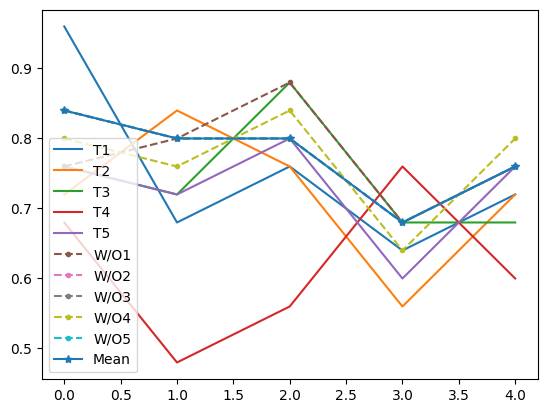

In [47]:
for i in range(5):
    plt.plot(lrValidScores[i], label=f'T{i+1}')
plt.legend()
for i in range(5):
    plt.plot(lrValidScores[i+5], '.--',label=f'W/O{i+1}')
plt.plot(lrValidScores[10], '*-',label=f'Mean')
plt.legend()

In [48]:
np.mean(np.array(lrValidScores),axis=1)

array([0.752, 0.72 , 0.744, 0.616, 0.728, 0.776, 0.776, 0.776, 0.768,
       0.776, 0.776])

In [49]:
indexs = []
for i in range(1,12):
    if i < 6:
        indexs.append(f'T{i}')
    elif i != 11:
        indexs.append(f'W/O T{i-5}')
    else:
        indexs.append('Mean')

In [50]:
pd.DataFrame(np.array(lrValidScores), columns=['T1','T2','T3','T4','T5'], index= indexs)

,T1,T2,T3,T4,T5
T1,0.96,0.68,0.76,0.64,0.72
T2,0.72,0.84,0.76,0.56,0.72
T3,0.76,0.72,0.88,0.68,0.68
T4,0.68,0.48,0.56,0.76,0.60
T5,0.76,0.72,0.80,0.60,0.76
W/O T1,0.76,0.80,0.88,0.68,0.76
W/O T2,0.84,0.80,0.80,0.68,0.76
W/O T3,0.84,0.80,0.80,0.68,0.76
W/O T4,0.80,0.76,0.84,0.64,0.80
W/O T5,0.84,0.80,0.80,0.68,0.76


### test

## Model Selection with L1 regularlization

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [52]:
subSet = {}
bestParams = []
for i in range(1,6):
    max_score = 0
    bestParam = {'penalty':'l1', 'C':'0', 'solver':'liblinear'}
    for c in np.logspace(-2,2,5):
        scaler = StandardScaler()
        lr = LogisticRegression(penalty='l1',C=c,solver='liblinear')
        train_X = pd.concat((X, TrainTestDf[f'T{i}']),axis=1)
        train_X.dropna(inplace=True)
        X_train = np.hstack((scaler.fit_transform(train_X.iloc[:,:-1]), np.array(train_X.iloc[:,-1]).reshape(-1,1)))
        lrCv = cross_validate(lr,X_train[:,:-1],X_train[:,-1],n_jobs=-1,cv=X_train.shape[1])
        score = np.mean(lrCv['test_score'])
        if score > max_score:
            max_score = score
            bestParam['C'] = c
    bestParams.append(bestParam)

In [53]:
bestParams

[{'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear'},
 {'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear'},
 {'penalty': 'l1', 'C': 10.0, 'solver': 'liblinear'},
 {'penalty': 'l1', 'C': 10.0, 'solver': 'liblinear'},
 {'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear'}]

### Validation

In [54]:
lrModels = []
validProba = []
for i in range(5):
    scaler = StandardScaler()
    lr = LogisticRegression(**bestParams[i])
    scaler.fit(train_X.iloc[:,:-1])
    train_X = pd.concat((X, TrainTestDf[f'T{i+1}']),axis=1)
    train_X.dropna(inplace=True)
    X_train = np.hstack((scaler.transform(train_X.iloc[:,:-1]), np.array(train_X.iloc[:,-1]).reshape(-1,1)))
    fitLr = lr.fit(X_train[:,:-1],X_train[:,-1])
    lrModels.append((scaler, fitLr))
    X_valid = scaler.transform(train_X.iloc[:,:-1])
    validProba.append(fitLr.predict_proba(X_valid)[:,1])

In [55]:
coefs = []
for scaler, model in lrModels:
    coefs.append(model.coef_[0])
pd.DataFrame(coefs,columns=X.columns,index=['T1','T2','T3','T4','T5'])

,AnswerProba,ElseEntropy,AnswerEntropy,stdX,stdY,text_length,alphaWordCount,signWordCount,numericWordCount,avg_word_length
T1,-0.381697,0.230370,0.270132,-0.831501,-0.524533,0.000000,0.004116,0.000000,-0.386030,-0.766522
T2,-0.189338,0.673943,1.006322,0.134880,-0.317700,0.000000,0.076983,-0.106857,-0.140863,0.000000
T3,-1.450605,1.975882,1.029463,0.000000,0.000000,0.000000,1.121463,-0.336201,-2.371794,-0.242600
T4,-0.373091,-0.467929,-0.141686,-0.654232,0.535728,-3.968845,4.340156,0.635367,-0.445466,1.430068
T5,-0.646178,0.076312,0.132730,0.000000,-0.011600,0.000000,0.131166,0.000000,0.000000,-0.821658


In [56]:
validProba = np.array(validProba)

In [57]:
valPredict = pd.DataFrame()
for i in range(5):
    valPredict[f'lrPred{i}'] = pd.Series(validProba[i], index=train_X.index)
for i in range(5):
    valPredict[f'MeanW/O{i}'] = valPredict.iloc[:,:5].drop(f'lrPred{i}',axis=1).mean(axis=1)
valPredict['Mean'] = valPredict.iloc[:,:5].mean(axis=1)
valPredict.head()

,lrPred0,lrPred1,lrPred2,lrPred3,lrPred4,MeanW/O0,MeanW/O1,MeanW/O2,MeanW/O3,MeanW/O4,Mean
4,0.867974,0.815712,0.994692,0.728104,0.878781,0.854322,0.867388,0.822643,0.889290,0.851621,0.857053
16,0.651427,0.598298,0.257607,0.217223,0.475956,0.387271,0.400553,0.485726,0.495822,0.431139,0.440102
27,0.434259,0.769580,0.430798,0.604228,0.295696,0.525075,0.441245,0.525941,0.482583,0.559716,0.506912
56,0.312438,0.584884,0.753810,0.664302,0.476953,0.619987,0.551876,0.509644,0.532021,0.578859,0.558477
116,0.272315,0.544407,0.415526,0.497554,0.452580,0.477516,0.409493,0.441714,0.421207,0.432450,0.436476


In [58]:
lrValidScores = []
for m in range(11):
    if m == 10:
        modelName = 'Mean'
    else:
        modelName = f'lrPred{m}' if m < 5 else f'MeanW/O{m-5}'
    qualityDf['pred'] = qualityDf.apply(lambda x: 1 if valPredict.loc[x['left'],modelName] > valPredict.loc[x['right'],modelName] else 2, axis=1)
    qualityDf.rename({'T1_ALR':'T1','T2_CL':'T2','T3_GF':'T3','T4_MQ':'T4','T5_NS':'T5'},axis=1,inplace=True)
    scoreList = []
    for i in range(1,6):
        scoreList.append(np.mean(qualityDf[f'T{i}'] == qualityDf['pred']))
    lrValidScores.append(scoreList)

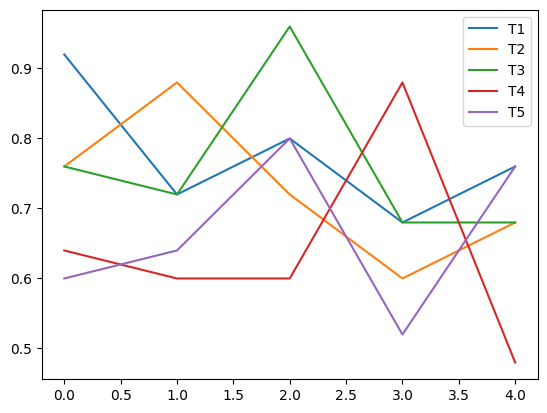

In [59]:
for i in range(5):
    plt.plot(lrValidScores[i], label=f'T{i+1}')
plt.legend()

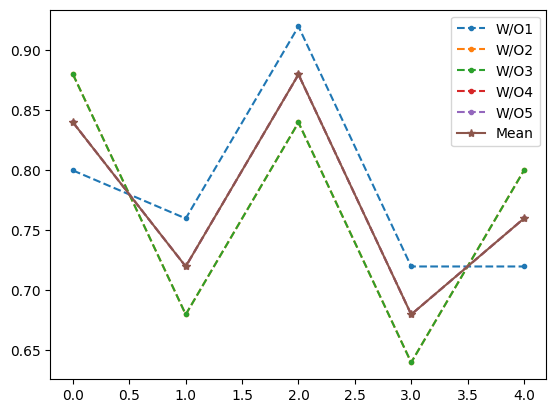

In [60]:
for i in range(5):
    plt.plot(lrValidScores[i+5], '.--',label=f'W/O{i+1}')
plt.plot(lrValidScores[10], '*-',label=f'Mean')
plt.legend()

In [61]:
np.mean(lrValidScores,axis=1)

array([0.776, 0.728, 0.76 , 0.64 , 0.664, 0.784, 0.768, 0.768, 0.776,
       0.776, 0.776])

In [62]:
indexs = []
for i in range(1,12):
    if i < 6:
        indexs.append(f'T{i}')
    elif i != 11:
        indexs.append(f'W/O T{i-5}')
    else:
        indexs.append('Mean')

In [63]:
pd.DataFrame(np.array(lrValidScores), columns=['T1','T2','T3','T4','T5'], index= indexs)

,T1,T2,T3,T4,T5
T1,0.92,0.72,0.80,0.68,0.76
T2,0.76,0.88,0.72,0.60,0.68
T3,0.76,0.72,0.96,0.68,0.68
T4,0.64,0.60,0.60,0.88,0.48
T5,0.60,0.64,0.80,0.52,0.76
W/O T1,0.80,0.76,0.92,0.72,0.72
W/O T2,0.88,0.68,0.84,0.64,0.80
W/O T3,0.88,0.68,0.84,0.64,0.80
W/O T4,0.84,0.72,0.88,0.68,0.76
W/O T5,0.84,0.72,0.88,0.68,0.76


## Test

In [64]:
lrPred = []
for i, model in enumerate(lrModels):
    scaler, model = model
    testX = scaler.transform(testDf)
    lrPred.append(model.predict_proba(testX)[:,1])

In [65]:
predict = pd.DataFrame()
for i in range(5):
    predict[f'lrPred{i}'] = pd.Series(lrPred[i], index=testDf.index)
predict['Mean'] = predict.drop('lrPred0',axis=1).mean(axis=1)

In [66]:
scoreList = []
modelName = 'Mean'
testTaskDf['pred'] = testTaskDf.apply(lambda x: 1 if predict.loc[x['left'],modelName] > predict.loc[x['right'],modelName] else 2, axis=1)
testTaskDf.rename({'T1_ALR':'T1','T2_CL':'T2','T3_GF':'T3','T4_MQ':'T4','T5_NS':'T5'},axis=1,inplace=True)
for i in range(1,6):
    scoreList.append(np.mean(testTaskDf[f'T{i}'] == testTaskDf['pred']))
pd.DataFrame(np.array(scoreList).reshape(1,-1), columns=['T1','T2','T3','T4','T5'])

,T1,T2,T3,T4,T5
0,0.68,0.64,0.64,0.72,0.84
